# Brain Tumor Detection using Convolutional Neural Network

### Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
     
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
from absl import logging
logging._warn_preinit_stderr = 0
logging.warning('Worrying Stuff')

W0516 09:55:19.427740  7664 <ipython-input-2-b63d91235356>:3] Worrying Stuff


## Data Preparation & Preprocessing¶
### Step 1: Cropping the part of the image that contains the brain
    This was done using a cropping technique to find the extreme top, bottom, left and right points of the brain using OpenCV.

In [3]:
#Function to crop the image
def crop_img(image, plot = False):
    #Convert the img to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    #threshold the image 
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    #performing morphological operations dilation and erosion to remove any small regions of noise
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations = 2)
    
    #find contours in the thresholded image, find the maximum one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

#### Applying the crop function to an image from the dataset

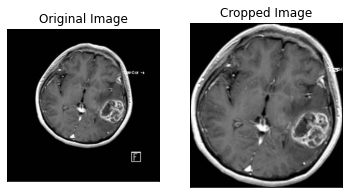

In [6]:
ex_img = cv2.imread('dataset/yes/Y29.jpg')
ex_new_img = crop_img(ex_img, True)

### Step 2: Resizing the images
### Step 3: Apply Normalization

    The function below does the following:
    1. Read the image
    2. Crop the part of the image containing only the brain
    3. Resize the image (because the image in the dataset is of different sizes (width, height and # of channels) so we want
       all our images to be of size(240,240,3) to feed it as an input to the neural network
    4. Apply normalization as we want our pixel values to be scaled to the range 0-1
    5. Append the image to X and its label to y
    After that shuffle X and y, because our data is ordered(i.e. the arrays contain the first part belonging to one class(Yes)     and the second belonging to the other(No).
    Finally, return X and y

In [4]:
def load_data(dir_list, image_size):
    '''
        Arguements: 
            dir_list: list of strings representing file directories
            image_size: image width, image height
        Returns:
            X: a numpy array with shape = (#_of_examples, img_width, img_height, #_of_channels)
            y: a numpy array with shape = (#_of_examples, 0/1)
    '''
    X = []
    y = []
    img_width, img_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + "\\" + filename)
            image = crop_img(image, plot = False)
            image = cv2.resize(image, dsize = (img_width, img_height), interpolation=cv2.INTER_CUBIC)
            #normalize values
            image = image/255
            #append the image to X
            X.append(image)
            #append a value of 1 into the target array 
            #if image is in folder named 'yes' otherwise append 0
            if(directory[-3:] == 'yes'):
                y.append([1])
            else:
                y.append([0])
        
    X = np.array(X)
    y = np.array(y)
    
    #shuffle the data
    X, y = shuffle(X,y)
    
    print(f"Number of examples: {len(X)}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    return X, y

In [12]:
#img = cv2.imread('augmented_data/yes/aug_Y100_0_2716.jpg')
#img.shape

(348, 287, 3)

#### We load up the augmented data that we generated in the Data Augmentation notebook

In [7]:
augmented_path = 'augmented_data/'

#augmented data contains both the original images and newly generated images
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240,240)

X, y = load_data([augmented_yes, augmented_no], [IMG_WIDTH, IMG_HEIGHT])

Number of examples: 2064
X shape: (2064, 240, 240, 3)
y shape: (2064, 1)


##### As we see we have 2064 images. Each image is of shape (240, 240, 3) = (img_width, img_height, # of channels.

### Plotting some example images

In [45]:
def plot_example_images(X, y, n = 50):
    '''
        Plot n sample images for both values of y
        X: a numpy array with shape = (#_of_examples, img_width, img_height, #_of_channels)
        y: a numpy array with shape = (#_of_examples, 0/1)
    '''
    
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_imgs = images[:n]
        
        cols = 10
        rows = int(n/cols)
        
        plt.figure(figsize = (20,10))
        
        i = 1;
        for image in n_imgs:
            plt.subplot(rows, cols, i)
            plt.imshow(image[0])
            
            #remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [46]:
print(X.shape)

(2064, 240, 240, 3)


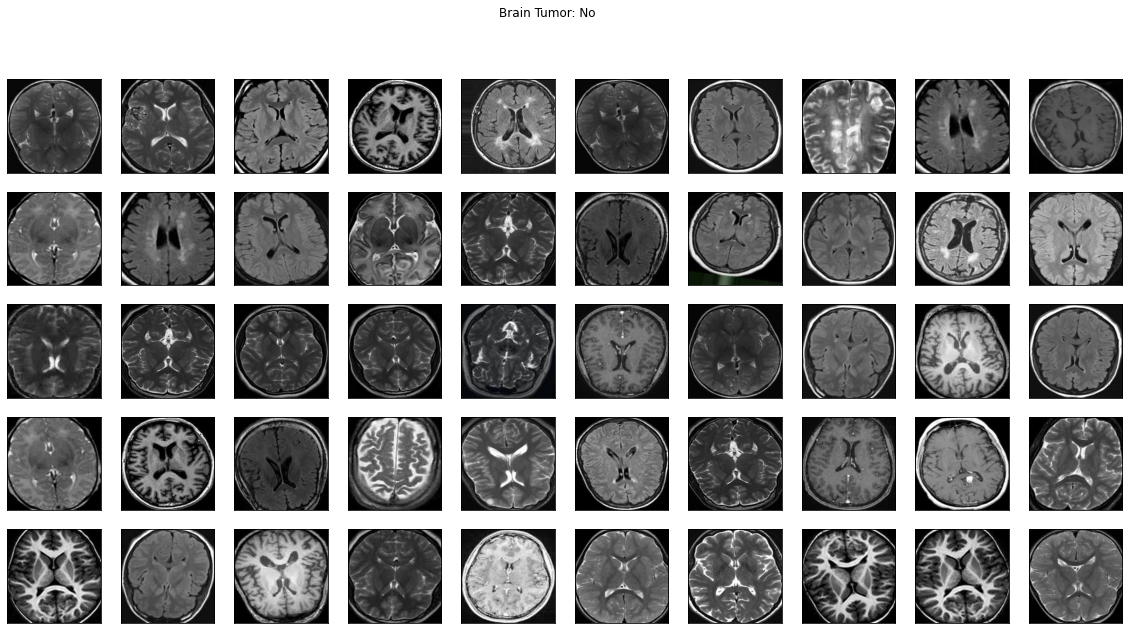

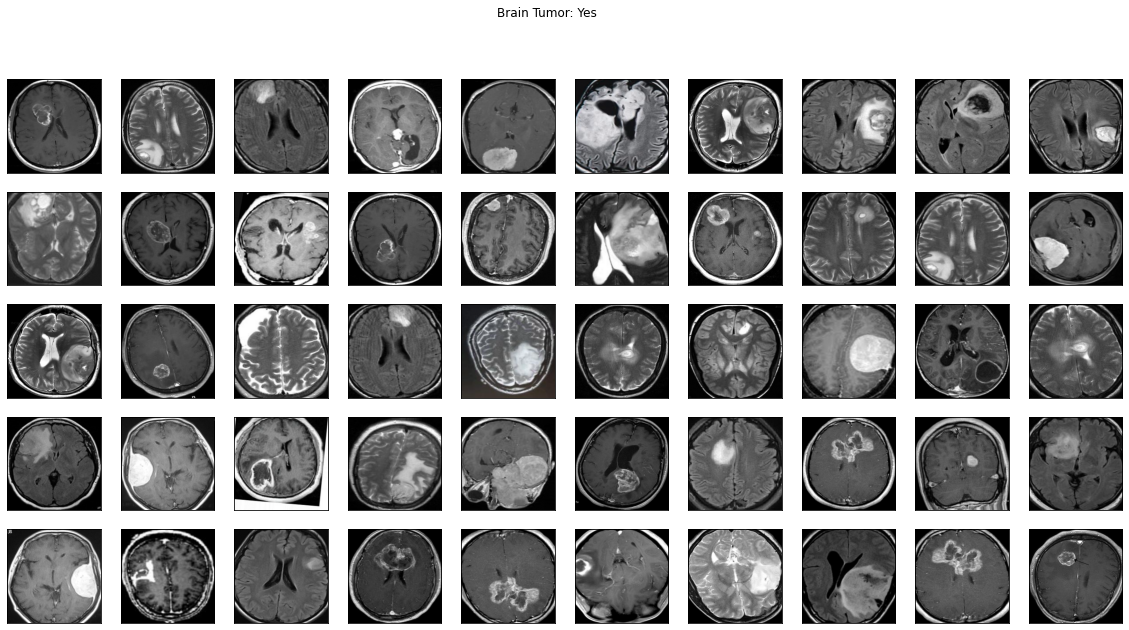

In [47]:
plot_example_images(X, y)

### Split the data
    Split X, y into training, validation and testing sets

In [5]:
def split_data(X, y, test_size = 0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

#### We split our data as follows:
        1. 70% data for training
        2. 15% data for validation
        3. 15% data for testing

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size = 0.3)

In [9]:
print("Number of training examples = " + str(X_train.shape[0]))
print("Number of validation examples = " + str(X_val.shape[0]))
print("Number of testing examples = " + str(X_test.shape[0]))
print("X_train shape = " + str(X_train.shape))
print("y_train shape = " + str(y_train.shape))
print("X_val shape = " + str(X_val.shape))
print("y_val shape = " + str(y_val.shape))
print("X_test shape = " + str(X_test.shape))
print("y_test shape = " + str(y_test.shape))

Number of training examples = 1444
Number of validation examples = 310
Number of testing examples = 310
X_train shape = (1444, 240, 240, 3)
y_train shape = (1444, 1)
X_val shape = (310, 240, 240, 3)
y_val shape = (310, 1)
X_test shape = (310, 240, 240, 3)
y_test shape = (310, 1)


### Some helper functions

In [14]:
def hms_string(sec_elapsed):
    h = (int)(sec_elapsed / (60 * 60))
    m = (int)((sec_elapsed % (60*60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s, 1)}"

In [15]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)
    
    return score

# Build the CNN Model

In [18]:
def build_model(input_shape):
    
    #define a tensor with shape as input_shape
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((2,2))(X_input)
    #shape becomes (?, 244, 244, 3)
    
    X = Conv2D(32, (7,7), strides = (1,1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    
    # FLATTEN X 
    X = Flatten()(X) 
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [19]:
IMG_SHAPE = (240, 240, 3)

In [26]:
model = build_model(IMG_SHAPE)

In [21]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [20]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

W0514 22:40:18.754518  6280 deprecation.py:323] From C:\Users\BHUMIKA\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'

In [22]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [23]:
start_time = time.time()
model.fit(x=X_train,y=y_train,batch_size = 32, epochs=25, validation_data=(X_val, y_val), callbacks = [checkpoint])

end_time = time.time()
exec_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(exec_time)}")

Train on 1444 samples, validate on 310 samples
Epoch 1/25
1444/1444 [==============================] - 109s 76ms/sample - loss: 0.6998 - acc: 0.6697 - val_loss: 0.6387 - val_acc: 0.6613
Epoch 2/25
1444/1444 [==============================] - 104s 72ms/sample - loss: 0.4611 - acc: 0.7825 - val_loss: 0.5891 - val_acc: 0.7258
Epoch 3/25
1444/1444 [==============================] - 106s 73ms/sample - loss: 0.4100 - acc: 0.8206 - val_loss: 0.6022 - val_acc: 0.6194
Epoch 4/25
1444/1444 [==============================] - 104s 72ms/sample - loss: 0.3643 - acc: 0.8331 - val_loss: 0.5033 - val_acc: 0.8000
Epoch 5/25
1444/1444 [==============================] - 105s 73ms/sample - loss: 0.3056 - acc: 0.8747 - val_loss: 0.5326 - val_acc: 0.6935
Epoch 6/25
1444/1444 [==============================] - 106s 73ms/sample - loss: 0.3189 - acc: 0.8712 - val_loss: 0.6202 - val_acc: 0.6806
Epoch 7/25
1444/1444 [==============================] - 103s 72ms/sample - loss: 0.2740 - acc: 0.8940 - val_loss: 0.693

In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1444 samples, validate on 310 samples
Epoch 1/5
1444/1444 [==============================] - 108s 75ms/sample - loss: 0.2190 - acc: 0.9120 - val_loss: 0.3088 - val_acc: 0.8774
Epoch 2/5
1444/1444 [==============================] - 112s 77ms/sample - loss: 0.2446 - acc: 0.9010 - val_loss: 0.8281 - val_acc: 0.6645
Epoch 3/5
1444/1444 [==============================] - 111s 77ms/sample - loss: 0.2101 - acc: 0.9204 - val_loss: 0.4127 - val_acc: 0.8258
Epoch 4/5
1444/1444 [==============================] - 106s 74ms/sample - loss: 0.1684 - acc: 0.9432 - val_loss: 0.3176 - val_acc: 0.8742
Epoch 5/5
1444/1444 [==============================] - 106s 74ms/sample - loss: 0.1434 - acc: 0.9543 - val_loss: 0.2699 - val_acc: 0.9032
Elapsed time: 0:9:3.5


In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1444 samples, validate on 310 samples
Epoch 1/5
1444/1444 [==============================] - 106s 73ms/sample - loss: 0.1640 - acc: 0.9398 - val_loss: 0.3719 - val_acc: 0.8355
Epoch 2/5
1444/1444 [==============================] - 103s 71ms/sample - loss: 0.1547 - acc: 0.9467 - val_loss: 0.4956 - val_acc: 0.7903
Epoch 3/5
1444/1444 [==============================] - 101s 70ms/sample - loss: 0.1589 - acc: 0.9460 - val_loss: 0.2724 - val_acc: 0.8774
Epoch 4/5
1444/1444 [==============================] - 109s 76ms/sample - loss: 0.1408 - acc: 0.9481 - val_loss: 0.2736 - val_acc: 0.8903
Epoch 5/5
1444/1444 [==============================] - 109s 76ms/sample - loss: 0.1518 - acc: 0.9418 - val_loss: 0.4741 - val_acc: 0.8194
Elapsed time: 0:8:48.8


In [30]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Train on 1444 samples, validate on 310 samples
Epoch 1/5
1444/1444 [==============================] - 104s 72ms/sample - loss: 0.1481 - acc: 0.9439 - val_loss: 0.4281 - val_acc: 0.8387
Epoch 2/5
1444/1444 [==============================] - 98s 68ms/sample - loss: 0.1218 - acc: 0.9564 - val_loss: 0.3962 - val_acc: 0.8452
Epoch 3/5
1444/1444 [==============================] - 99s 69ms/sample - loss: 0.0885 - acc: 0.9771 - val_loss: 0.2631 - val_acc: 0.8839
Epoch 4/5
1444/1444 [==============================] - 107s 74ms/sample - loss: 0.0943 - acc: 0.9709 - val_loss: 0.3035 - val_acc: 0.8677
Epoch 5/5
1444/1444 [==============================] - 107s 74ms/sample - loss: 0.1116 - acc: 0.9633 - val_loss: 0.4366 - val_acc: 0.8419
Elapsed time: 0:8:33.9


In [24]:
history = model.history.history

In [25]:
for key in history.keys():
    print(key)

loss
acc
val_loss
val_acc


In [26]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

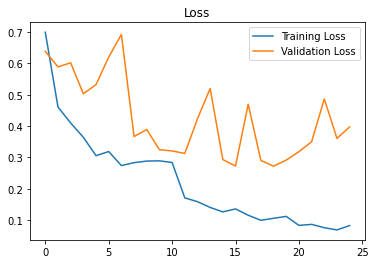

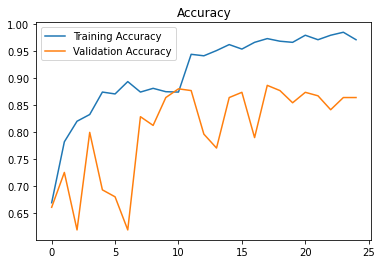

In [27]:
plot_metrics(history)

## Results
    We experiment with the best model (best validation accuracy)
    We load model with accuracy 90%

### Load the best model

In [10]:
best_model = load_model(filepath="models/cnn-parameters-improvement-05-0.90.model")

W0516 09:58:54.306291  7664 deprecation.py:506] From C:\Users\BHUMIKA\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0516 09:58:54.321912  7664 deprecation.py:506] From C:\Users\BHUMIKA\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0516 09:58:54.326463  7664 deprecation.py:506] From C:\Users\BHUMIKA\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is depreca

In [57]:
best_model.metrics_names

['loss', 'acc']

In [58]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

310/310 [==============================] - 9s 28ms/sample - loss: 0.1927 - acc: 0.9355


### Accuracy of the best model on the testing data

In [59]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.1926716894872727
Test Accuracy = 0.9354838728904724


### F1 score for the best model on the testing data

In [60]:
y_test_prob = best_model.predict(X_test)

In [61]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9382716049382717


#### F1 score on the validation data

In [34]:
y_val_prob = best_model.predict(X_val)

In [35]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9483282674772037


### Results Interpretation

In [36]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [37]:
data_percentage(y)

Number of examples: 2064
Percentage of positive examples: 52.616279069767444%, number of pos examples: 1086
Percentage of negative examples: 47.383720930232556%, number of neg examples: 978


In [38]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1444
Percentage of positive examples: 52.70083102493075%, number of pos examples: 761
Percentage of negative examples: 47.29916897506925%, number of neg examples: 683
Validation Data:
Number of examples: 310
Percentage of positive examples: 52.903225806451616%, number of pos examples: 164
Percentage of negative examples: 47.096774193548384%, number of neg examples: 146
Testing Data:
Number of examples: 310
Percentage of positive examples: 51.935483870967744%, number of pos examples: 161
Percentage of negative examples: 48.064516129032256%, number of neg examples: 149


## Conclusion
    The model predicts brain tumor with:
    93% accuracy on the test set
    0.93 f1 score on the test set
    
### Performance table:
            Validation set	  Test set
            Accuracy	94%	    93.8%
            F1 score	0.94	0.93

In [27]:
#save model
model.save('brain_tumor_model.h5')